<a href="https://colab.research.google.com/github/ByvatovS/ML_Task/blob/main/Work2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install folium

In [10]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)


Задание 1 (1 балл). Мы будем работать с данными из соревнования New York City Taxi Trip Duration, в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [11]:
train = pd.read_csv("/DataSet/train.csv")
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0


Обратите внимание на колонки pickup_datetime и dropoff_datetime. dropoff_datetime был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В pickup_datetime записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в datetime-объекты

In [12]:
train=train.drop(columns="dropoff_datetime")
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'])
train.head(3)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0


In [13]:
train.dtypes

,0
id,object
vendor_id,int64
pickup_datetime,datetime64[ns]
passenger_count,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
store_and_fwd_flag,object
trip_duration,float64


В колонке trip_duration записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

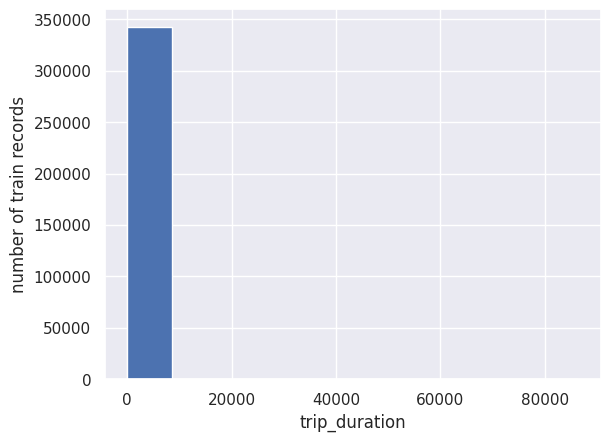

In [14]:
plt.hist(train['trip_duration'].values)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

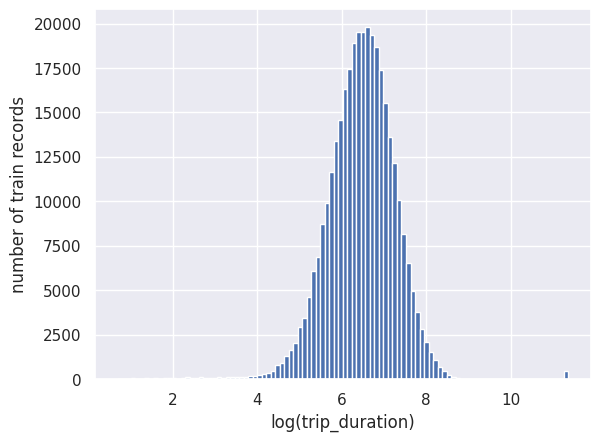

In [15]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()


In [16]:
train=train.drop(columns='trip_duration')
train.head(3)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [17]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt( np.sum( np.power((log1p_y_true - log1p_y_pred) ,2) ) / len(log1p_y_pred) )
    # raise NotImplementedError

discr=train.describe()
mean_y = discr['log_trip_duration']['mean']
mean_y = [mean_y]*len(train['log_trip_duration'])
rmsle_best_const = rmsle(train['log_trip_duration'],mean_y)
print(rmsle_best_const)
# assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7960679859772611


Часть 1. Изучаем pickup_datetime (2 балла)

Задание 2 (0.25 баллов). Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться sns.countplot):

In [18]:
train['day_of_year']=train['pickup_datetime'].dt.dayofyear

date_data=train.groupby('day_of_year')[['passenger_count']].sum()
date_data

,passenger_count
day_of_year,
1,2935
2,2836
3,2681
4,2409
5,2894
...,...
178,2759
179,2794
180,2767


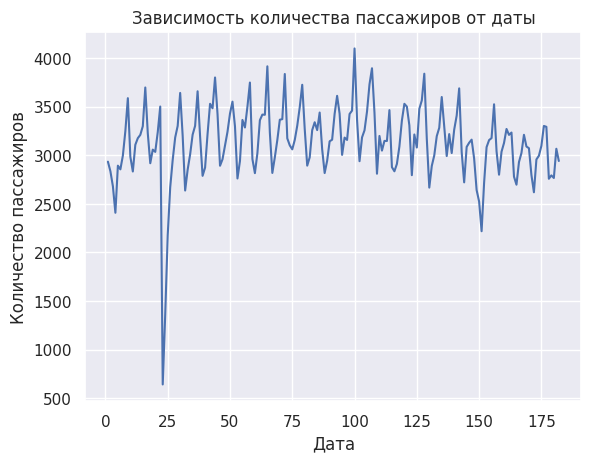

In [19]:
plt.plot(date_data.index, date_data['passenger_count'])
plt.title('Зависимость количества пассажиров от даты')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.grid(True)
plt.show()

Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь sns.relplot):

In [20]:
date_data['passenger_count'].nsmallest(10)

,passenger_count
day_of_year,
23,641
24,1361
25,2176
151,2219
4,2409
150,2525
172,2620
32,2638
149,2643


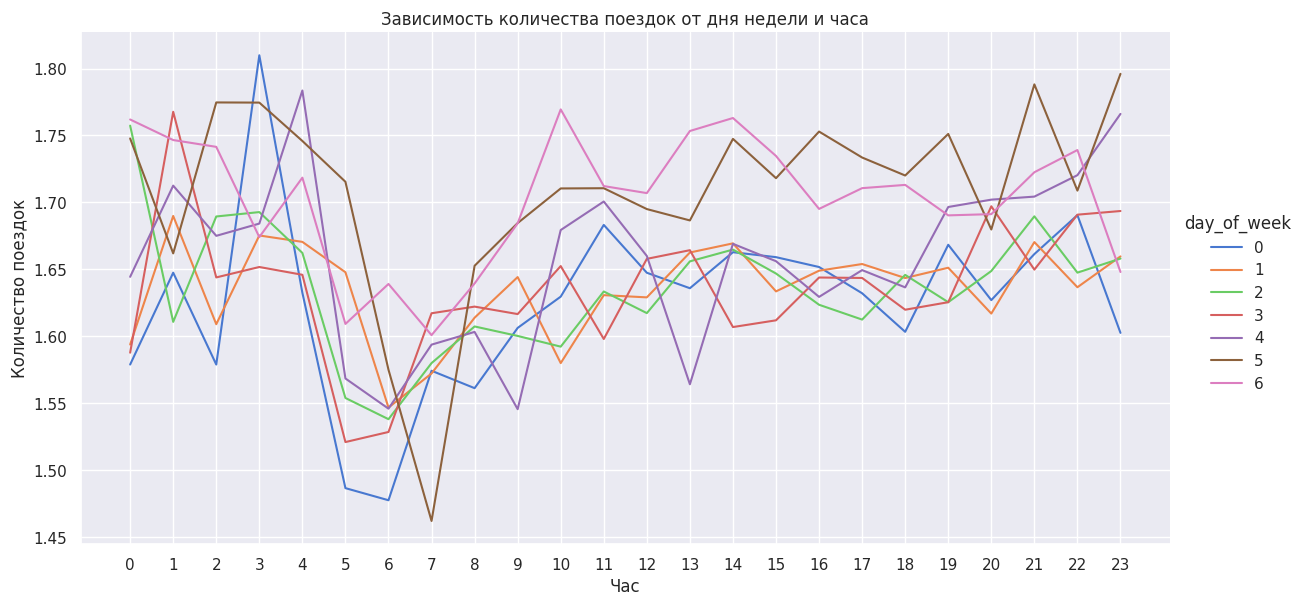

In [21]:
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['hour'] = train['pickup_datetime'].dt.hour


grouped_data = train.groupby(by=['day_of_week', 'hour'])[['passenger_count']].mean()


sns.relplot(x='hour', y='passenger_count', hue='day_of_week', data=grouped_data, kind='line',
            height=6, aspect=2,
            palette="muted")


plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.title('Зависимость количества поездок от дня недели и часа')
plt.xticks(range(24))
plt.show()

Задание 3 (0.5 баллов). Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь hue в sns.relplot). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

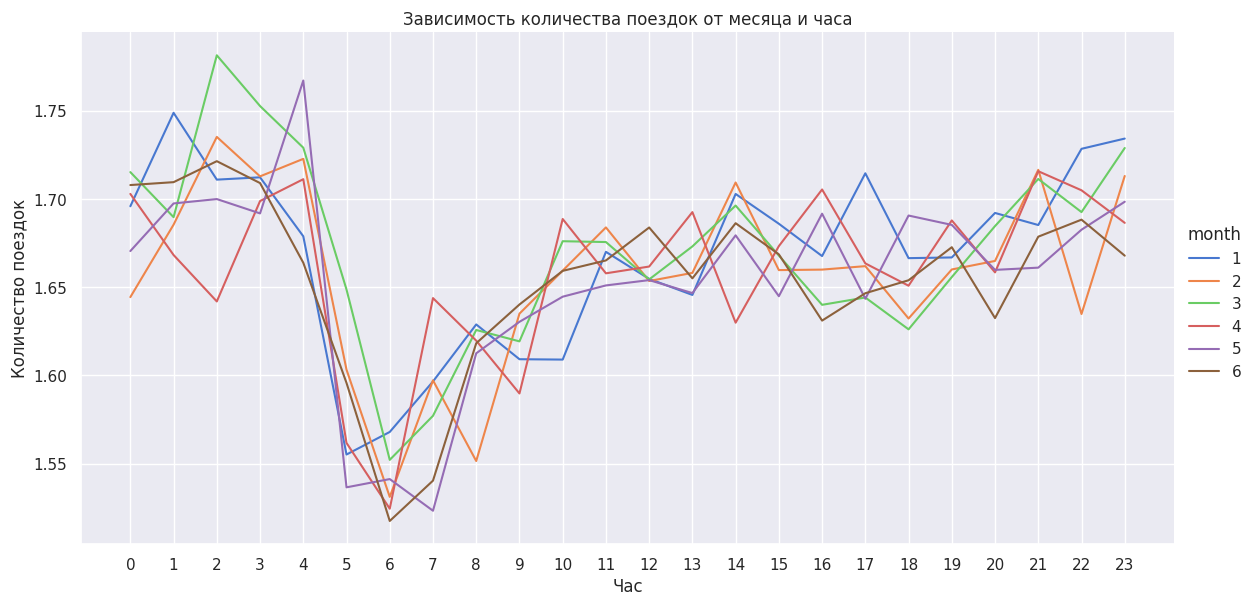

In [22]:
train['month'] = train['pickup_datetime'].dt.month

grouped_data = train.groupby(['month', 'hour'])[['passenger_count']].mean()


sns.relplot(x='hour', y='passenger_count', hue='month', data=grouped_data, kind='line',
            height=6, aspect=2,
            palette="muted")


plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.title('Зависимость количества поездок от месяца и часа')
plt.xticks(range(24))
plt.show()

Задание 4 (0.5 баллов). Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте train_test_split из sklearn). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [23]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train, test_size=0.3, random_state=10)

<ipython-input-24-86dfa253ff92>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(x='day_of_week', y='log_trip_duration', data=grouped_data, kind='line',


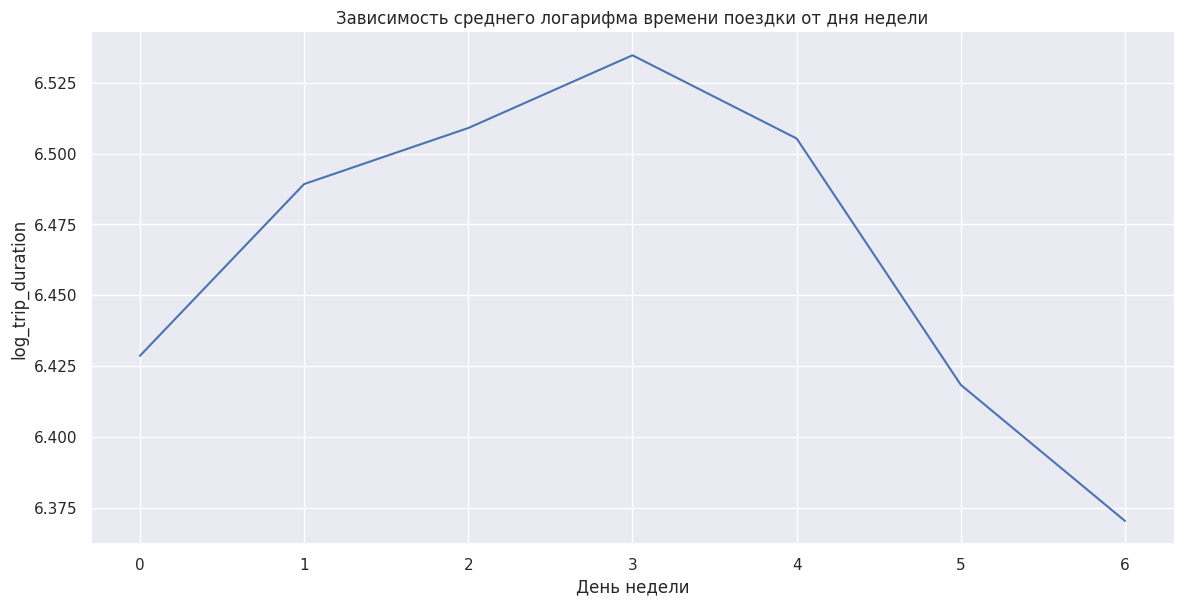

In [24]:
grouped_data = train_data.groupby(by=['day_of_week'])[['log_trip_duration']].mean()


sns.relplot(x='day_of_week', y='log_trip_duration', data=grouped_data, kind='line',
            height=6, aspect=2,
            palette="muted")


plt.xlabel('День недели')
plt.ylabel('log_trip_duration')
plt.title('Зависимость среднего логарифма времени поездки от дня недели')
plt.xticks(range(7))
plt.show()

<ipython-input-25-91d7282fbafd>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(x='hour', y='log_trip_duration', data=grouped_data, kind='line',


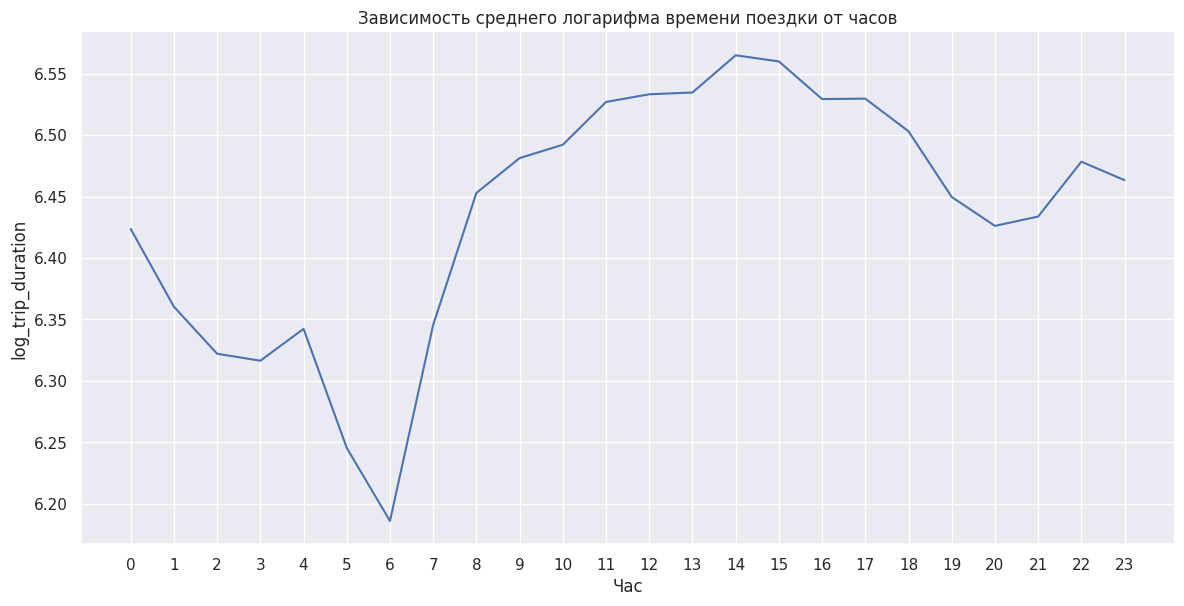

In [25]:
grouped_data = train_data.groupby(by=['hour'])[['log_trip_duration']].mean()


sns.relplot(x='hour', y='log_trip_duration', data=grouped_data, kind='line',
            height=6, aspect=2,
            palette="muted")


plt.xlabel('Час')
plt.ylabel('log_trip_duration')
plt.title('Зависимость среднего логарифма времени поездки от часов')
plt.xticks(range(24))
plt.show()

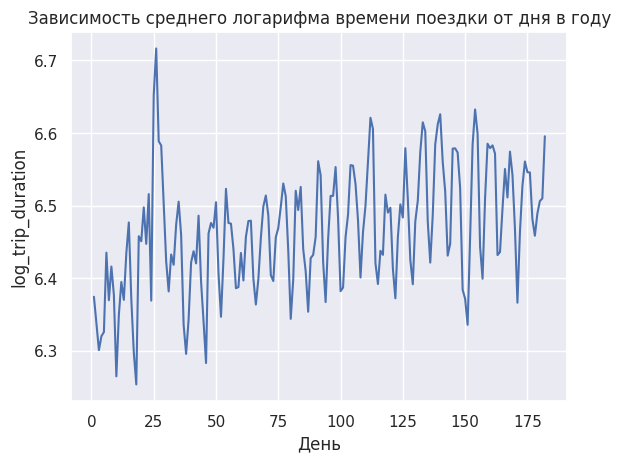

In [26]:
grouped_data = train_data.groupby(by=['day_of_year'])[['log_trip_duration']].mean()


plt.plot(grouped_data.index, grouped_data['log_trip_duration'])

plt.grid(True)
plt.xlabel('День')
plt.ylabel('log_trip_duration')
plt.title('Зависимость среднего логарифма времени поездки от дня в году')
plt.show()

In [27]:
train_data['Anomaly_flg'] = 0
train_data.loc[train_data['day_of_year']==23] = 1
train_data.loc[train_data['day_of_year']==24] = 1
train_data.loc[train_data['day_of_year']==151] = 1
train_data.head(4)

<ipython-input-27-118ff9abd831>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  train_data.loc[train_data['day_of_year']==23] = 1


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_year,day_of_week,hour,month,Anomaly_flg
113780,id1283761,1,2016-01-13 15:12:20,1,-73.982529,40.762218,-73.990723,40.751148,N,5.560682,13,2,15,1,0
89209,id1976581,2,2016-02-29 12:45:10,5,-73.952682,40.787556,-73.973816,40.763947,N,6.690842,60,0,12,2,0
4443,id2174499,1,2016-02-06 14:10:21,1,-74.002678,40.728676,-73.979462,40.749672,N,6.706862,37,5,14,2,0
64615,id1595141,2,2016-02-11 21:06:47,2,-73.997482,40.744839,-73.955261,40.695011,N,7.525101,42,3,21,2,0


In [29]:
test_data['Anomaly_flg'] = 0

Обучите Ridge-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью OneHotEncoder. Численные признаки отмасштабируйте с помощью StandardScaler. Используйте только признаки, которые мы выделили в этой части задания.

In [33]:
tr_d=train_data[["log_trip_duration","day_of_year","day_of_week","month","hour","passenger_count","Anomaly_flg"]]
test_d=test_data[["log_trip_duration","day_of_year","day_of_week","month","hour","passenger_count","Anomaly_flg"]]
tr_d.head(3)

,log_trip_duration,day_of_year,day_of_week,month,hour,passenger_count,Anomaly_flg
113780,5.560682,13,2,1,15,1,0
89209,6.690842,60,0,2,12,5,0
4443,6.706862,37,5,2,14,1,0


In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = ["day_of_year","day_of_week","month","hour","Anomaly_flg"]  # Замените на ваши категориальные столбцы
numerical_cols = ['passenger_count']

y_train = tr_d["log_trip_duration"]
X_train = tr_d.drop(columns=["log_trip_duration"])
y_test = test_d["log_trip_duration"]
X_test = test_d.drop(columns=["log_trip_duration"])

ohe = OneHotEncoder(handle_unknown='ignore')
train_encoded = ohe.fit_transform(X_train[categorical_cols]).toarray()
test_encoded = ohe.transform(X_test[categorical_cols]).toarray()

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train[numerical_cols])
test_scaled = scaler.transform(X_test[numerical_cols])



X_train_final = np.concatenate((train_encoded, train_scaled), axis=1)
X_test_final = np.concatenate((test_encoded, test_scaled), axis=1)



array([[ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.50249757],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  2.56230439],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.50249757],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.26370292],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        , -0.50249757],
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.        , -0.50249757]])

In [38]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train_final, y_train)
y_test_pred = model.predict(X_test_final)

rmsle_test = rmsle(y_test_pred,y_test)
print(f"Test RMSE = {rmsle_test}")

Test RMSE = 0.7913204203999455
